## Fault Classification of Rolling Element Bearings

The [dataset](https://engineering.case.edu/bearingdatacenter) contains vibration data collected using accelerometers, which were attached to the housing with magnetic bases. Accelerometers were placed at the 12 o’clock position at both the drive end and fan end of the motor housing. During some experiments, an accelerometer was attached to the motor supporting base plate as well. Vibration signals were collected using a 16 channel DAT recorder, and were post processed in a Matlab environment. All data files are in Matlab (*.mat) format. Digital data was collected at 12,000 samples per second, and data was also collected at 48,000 samples per second for drive end bearing faults. Speed and horsepower data were collected using the torque transducer/encoder and were recorded by hand.

The test stand consists of a 2 hp motor (left), a torque transducer/encoder (center), a dynamometer (right), and control electronics (not shown). The test bearings support the motor shaft. Single point faults were introduced to the test bearings using electro-discharge machining with fault diameters of 7 mils, 14 mils, 21 mils, 28 mils, and 40 mils (1 mil=0.001 inches). 

![alt text](./imm/CWRU_teststand.jpeg)

Outer raceway faults are stationary faults, therefore placement of the fault relative to the load zone of the bearing has a direct impact on the vibration response of the motor/bearing system. In order to quantify this effect, experiments were conducted for both fan and drive end bearings with outer raceway faults located at 3 o’clock (directly in the load zone), at 6 o’clock (orthogonal to the load zone), and at 12 o’clock.

This data will be used to classify the fault modes of these bearings.

In [1]:
#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from src import config, preprocess
from src.data_import import readData
from src.feature_extraction import extractDatasetFeatures
from src.engine import nestedKFoldCV

## Read data

In [2]:
df = readData() # Parse dataset

print(f'No. records: {df.shape[0]}')
noClasses = len(set(df['Label']))
print(f'No. classes: {noClasses}')

No. records: 161
No. classes: 7


Problems with the files encountered while parsing the data:
* Some files contain vibrations for more than one experiments. For instance file 99.mat contains the data also for 98.mat
* Some files only contain vibrations for one of the two bearings.
* In some files the file number and the variable numbers do not match. These are assumed to be correct (something has to be assumed)
* Some files are sampled in a different frequency (48 kHz instead of 12 kHz)

## Quick EDA

In [3]:
fanRecords   = [True if elem is not None else False for elem in df['FanVibs'] ]
driveRecords = [True if elem is not None else False for elem in df['DriveVibs'] ]
print(f'Total records: {df.shape[0]}')
print(f'No. records with FanEnd bearing vibrations: {np.sum( fanRecords )}')
print(f'No. records with DriveEnd bearing vibrations: {np.sum( driveRecords )}')

Total records: 161
No. records with FanEnd bearing vibrations: 153
No. records with DriveEnd bearing vibrations: 161


In [4]:
noSamples   = []
for idx, record in df.iterrows():
    
    if record['FanVibs'] is None: fanSample = 0
    else: fanSample = record['FanVibs'].shape[0]
    
    driveSample = record['DriveVibs'].shape[0]
    
    if fanSample != driveSample:
        print(f'Different no. samples for the two bearings (drive: {driveSample} / fan: {fanSample}) found on record: {idx}')
    
    noSamples.append(fanSample)

df['noSamples'] = noSamples

Different no. samples for the two bearings (drive: 120801 / fan: 0) found on record: 16
Different no. samples for the two bearings (drive: 121351 / fan: 0) found on record: 17
Different no. samples for the two bearings (drive: 121351 / fan: 0) found on record: 18
Different no. samples for the two bearings (drive: 121535 / fan: 0) found on record: 19
Different no. samples for the two bearings (drive: 120801 / fan: 0) found on record: 56
Different no. samples for the two bearings (drive: 121351 / fan: 0) found on record: 57
Different no. samples for the two bearings (drive: 120984 / fan: 0) found on record: 58
Different no. samples for the two bearings (drive: 120984 / fan: 0) found on record: 59


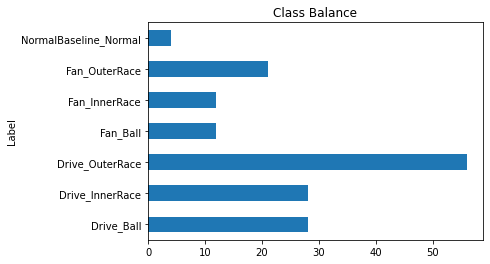

In [5]:
df.groupby('Label').count()['noSamples'].plot(kind = 'barh', title = 'Class Balance');

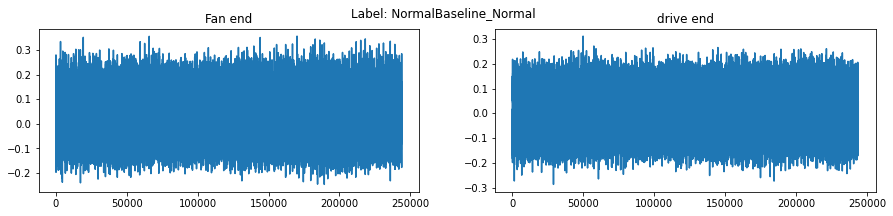

In [6]:
idx =0 # File to plot

fanvib   = df['FanVibs'].iloc[idx]
drivevib = df['DriveVibs'].iloc[idx]

fig, ax = plt.subplots(figsize = (15, 3), nrows = 1, ncols = 2)
ax[0].plot(fanvib);
ax[1].plot(drivevib);
plt.suptitle('Label: ' + df['Label'].iloc[idx]);
ax[0].set_title('Fan end')
ax[1].set_title('drive end');
plt.show()

## Preprocessing

In [7]:
# Downsample the 48kHz-sampled records
df = preprocess.downsample48kHzVibrations(df)

# Resample the vibration signals to have the same number of records each (10 sec)
df = preprocess.resampleVibrations(df, noSamples = 10 * config.Fs)

# Make specific labels for each  bearing (one model per bearing will be trained)
df['DriveLabel'], df['FanLabel'] = preprocess.makeBearingLabels(df['Label'])
df.drop('Label', axis = 1, inplace = True)

## Feature Engineering

Frequency domain features include:
* Top k levels
* Top k frequencies

For each frequency band from:
* 0-150 [Hz]
* 150 - 300 [Hz]
* 300 - 1500 [Hz]
* 1500 - all [Hz]

Time domain features include:

* RMS value
* Mean value
* Min, max values
* Standard deviation
* Skewness
* Kurtosis
* Peak-to-peak value
* Crest factor
* Impulse factor
* Shape factor

In [8]:
dfDrive, dfFan = extractDatasetFeatures(df)

  0%|          | 0/157 [00:00<?, ?it/s]

### Modelling

One model will be made for the drive-end bearing and one for the fan-end bearing.
Nested k-fold CV will be performed with random search for the hyperparameters.

  0%|          | 0/10 [00:00<?, ?it/s]

                 precision    recall  f1-score   support

     Drive_Ball       0.81      0.88      0.85        25
Drive_InnerRace       0.96      0.96      0.96        24
Drive_OuterRace       0.89      0.84      0.86        49
         Normal       0.93      0.95      0.94        59

       accuracy                           0.90       157
      macro avg       0.90      0.91      0.90       157
   weighted avg       0.91      0.90      0.90       157



  0%|          | 0/10 [00:00<?, ?it/s]

               precision    recall  f1-score   support

     Fan_Ball       0.91      0.83      0.87        12
Fan_InnerRace       1.00      0.92      0.96        12
Fan_OuterRace       0.87      0.95      0.91        21
       Normal       1.00      1.00      1.00       104

     accuracy                           0.97       149
    macro avg       0.94      0.93      0.93       149
 weighted avg       0.97      0.97      0.97       149



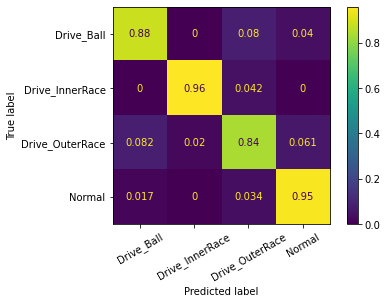

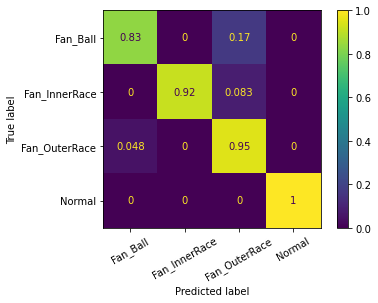

In [10]:
import lightgbm as lgb 

for idx, df in enumerate([dfDrive, dfFan]):
    
    X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
    enc  = LabelEncoder().fit(y)
    yenc = enc.transform(y)
    yhat = nestedKFoldCV(X, yenc)
    
    print(classification_report(yenc, yhat, target_names = list(enc.classes_)))
    ConfusionMatrixDisplay.from_predictions(yenc, yhat, 
                                            normalize       = 'true',
                                            display_labels  = list(enc.classes_), 
                                            xticks_rotation = 30);